In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from experiments2.auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt.networks.continuous_bn import ContinuousBN
from bamt.networks.hybrid_bn import HybridBN
from bamt_inherited.networks.discrete import DiscreteBNGI

from tqdm import tqdm
imagespath = 'error_gradation_images'

In [3]:
data = pd.read_csv("../../datasets/abalone.data", sep=',',
                   names=['sex', 'length', 'diameter', 'height', 'W_weight', 'S_weight', 'viscera_weight',
                          'shell_weight', 'rings'])
data = data[data["sex"] != "I"]
data["sex"] = data["sex"].replace({"F": 1, "M": 0})
data = data.reset_index().drop(columns=["index"])
n_features = data.shape[1] - 1
n = data.shape[0]
target = "sex"
features = data.columns.difference([target]).tolist()

data.head(10)

,sex,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,rings
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,1,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
5,1,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
6,0,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
7,1,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19
8,1,0.525,0.380,0.140,0.6065,0.1940,0.1475,0.210,14
9,0,0.430,0.350,0.110,0.4060,0.1675,0.0810,0.135,10


In [37]:
def entropy(a):
    vc = a.value_counts()
    vc /= vc.sum()
    return -(vc * np.log(vc)).sum()


def discretize(data, variables, icat, icont, contdiscstrategy="kmeans", n_bins=3):
    transformers_data = dict()

    if icat is None:  # в датасете только непрерывные фичи (и предиктор)
        pipeline = make_pipeline(
            KBinsDiscretizer(n_bins=n_bins, encode="ordinal", random_state=42, strategy=contdiscstrategy),
            FunctionTransformer(lambda x: x.astype("int")))
    elif icont is None:  # в датасете только категориальные фичи (и предиктор)
        pipeline = make_pipeline(
            OrdinalEncoder(categories="auto"),
            FunctionTransformer(lambda x: x.astype("int")))
    else:
        pipeline = make_pipeline(make_union(
            make_pipeline(FunctionTransformer(lambda x: x.iloc[:, icat]), OrdinalEncoder(categories="auto")),
            make_pipeline(FunctionTransformer(lambda x: x.iloc[:, icont]),
                          KBinsDiscretizer(n_bins=n_bins, encode="ordinal", random_state=42, strategy=contdiscstrategy))
        ),
            FunctionTransformer(lambda x: x.astype("int")))
        

    pipeline.fit(data)
    encoded_data = pd.DataFrame(pipeline.transform(data), columns=data.columns if icat is None or icont is None \
        else data.columns[icat + icont])
    encoded_data = encoded_data[
        variables]  # в общем случае пайплайн переставляет признаки, возвращаем их на их места здесь

    for feat in encoded_data.columns:
        if entropy(encoded_data[feat]) < 0.5:
            print(f"Warning: feature {feat} has practically degenerate states and low entropy")
    transformers_data["transformer"] = pipeline

    if icat is None:
        transformers_data["cont_features"] = list(pipeline.steps[0][1].get_feature_names_out())
        transformers_data["cont_features_edges"] = pipeline.steps[0][1].bin_edges_

    elif icont is None:
        transformers_data["cat_features"] = list(pipeline.steps[0][1].get_feature_names_out())
        transformers_data["cat_features_categories"] = pipeline.steps[0][1].categories_

    else:
        transformers_data["cont_features"] = list(
            pipeline.steps[0][1].named_transformers["pipeline-2"].steps[1][1].get_feature_names_out())
        transformers_data["cont_features_edges"] = pipeline.steps[0][1].named_transformers["pipeline-2"].steps[1][
            1].bin_edges_
        transformers_data["cat_features"] = list(
            pipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].get_feature_names_out())
        transformers_data["cat_features_categories"] = pipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][
            1].categories_

    #kmeanspipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].categories_[0]
    return encoded_data, transformers_data

In [38]:
#data_disc, tfdata = discretize(data, features, icat=None, icont=list(range(n_features)))
data = data[data["height"] < 0.26]
data_disc, tfdata = discretize(data, features, icat=None, icont=list(range(n_features)))

In [39]:
model = GradientBoostingClassifier(n_estimators=50)
#model = LogisticRegression()
model.fit(data[features], data[target])
data_errors = data.copy(deep=True)
probs = model.predict_proba(data[features])[:, 1]
data_errors["inconf_error"] = (1 - probs) * data[target] + (probs) * (
            1 - data[target])  #inconfidence measure: the larger the worser inconfidence
#data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,sex,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,rings,inconf_error
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0.271968
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0.240691
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0.548336
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0.469697
4,1,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20,0.539360


In [40]:
disc_data, pipeline_data = discretize(data_errors, features + ["inconf_error", target], icat=[0],
                                      icont=list(range(1, n_features + 2)))

In [41]:
current_error = data_errors["inconf_error"].sum() / n
current_error

0.4612121475189436

In [42]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore


def collect_all_cpds(bn_info, distributions, n_states_map):
    cpds = list()
    for index, row in bn_info.iterrows():
        feat = row["name"].name
        if len(row["parents"]) == 0:
            # cpd is just a pd
            cpd = TabularCPD(feat, n_states_map[feat], [[e] for e in distributions[feat]["cprob"]])
            cpds.append(cpd)
        else:
            cpd_list = [probs for probs in distributions[feat]["cprob"].values()]
            #cpd_list = [probs for i, probs in distributions[feat]["cprob"].items() if i[0]!="["]
            #print(cpd_list)
            nrows = len(cpd_list)
            ncols = len(cpd_list[0])
            cpd_list = [[cpd_list[i][j] for i in range(nrows)] for j in range(ncols)]
            #print(feat, row["parents"])
            #print(cpd_list)
            cpd = TabularCPD(feat, n_states_map[feat], cpd_list, evidence=row["parents"],
                             evidence_card=[n_states_map[p] for p in row["parents"]])
            cpds.append(cpd)
    return cpds



In [12]:
n_states_map = {feat: disc_data[feat].unique().shape[0] for feat in data_errors.columns}
n_states_map

{'sex': 2,
 'length': 3,
 'diameter': 3,
 'height': 3,
 'W_weight': 3,
 'S_weight': 3,
 'viscera_weight': 3,
 'shell_weight': 3,
 'rings': 3,
 'inconf_error': 3}

In [ ]:
from bamt.networks.base import STORAGE

In [43]:
#STORAGE = "C://Users/Дима/PycharmProjects/GIEBN/experiments/pgmpy_yodo_exps/bn_structures"

bn = DiscreteBN()
bn.add_nodes({"types": {feat: "disc" for feat in data_errors.columns}})

#blacklist = [("ent_error", x) for x in features]
#bn.add_edges(disc_data, scoring_function=("K2", K2Score))
#bn.fit_parameters(data=disc_data)

In [44]:
bn.add_edges(disc_data, scoring_function=("K2", BicScore))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [45]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,S_weight,Discrete,disc,[],[]
1,W_weight,Discrete,disc,[S_weight],[disc]
2,height,Discrete,disc,[W_weight],[disc]
3,inconf_error,Discrete,disc,"[W_weight, height]","[disc, disc]"
4,diameter,Discrete,disc,"[W_weight, height]","[disc, disc]"
5,length,Discrete,disc,"[S_weight, diameter]","[disc, disc]"
6,shell_weight,Discrete,disc,"[W_weight, diameter]","[disc, disc]"
7,viscera_weight,Discrete,disc,"[W_weight, length]","[disc, disc]"
8,rings,Discrete,disc,"[S_weight, shell_weight]","[disc, disc]"
9,sex,Discrete,disc,"[shell_weight, viscera_weight, inconf_error]","[disc, disc, disc]"


In [46]:
bn.nodes

[S_weight,
 W_weight,
 height,
 inconf_error,
 diameter,
 length,
 shell_weight,
 viscera_weight,
 rings,
 sex]

In [47]:
bn.fit_parameters(data=disc_data, n_jobs=1)

In [48]:
bn.distributions

{'S_weight': {'cprob': [0.3727497352629721,
   0.4712319096364278,
   0.15601835510060008],
  'vals': ['0', '1', '2']},
 'W_weight': {'cprob': {"['0']": [0.8229166666666666,
    0.17708333333333334,
    0.0],
   "['1']": [0.026217228464419477, 0.8741573033707866, 0.099625468164794],
   "['2']": [0.0, 0.13574660633484162, 0.8642533936651584]},
  'vals': ['0', '1', '2']},
 'height': {'cprob': {"['0']": [0.4502212389380531,
    0.5287610619469026,
    0.02101769911504425],
   "['1']": [0.02050919377652051, 0.6414427157001414, 0.33804809052333806],
   "['2']": [0.0, 0.0970873786407767, 0.9029126213592233]},
  'vals': ['0', '1', '2']},
 'inconf_error': {'cprob': {"['0', '0']": [0.3808353808353808,
    0.29238329238329236,
    0.32678132678132676],
   "['0', '1']": [0.04184100418410042, 0.5, 0.4581589958158996],
   "['0', '2']": [0.10526315789473684, 0.5263157894736842, 0.3684210526315789],
   "['1', '0']": [0.13793103448275862,
    0.5862068965517241,
    0.27586206896551724],
   "['1', '1'

In [49]:
np.random.seed(42)
he_data = bn.sample(n=5000, evidence={"inconf_error": 2})
le_data = bn.sample(n=5000, evidence={"inconf_error": 0})

100%|██████████| 5000/5000 [00:00<00:00, 9391.47it/s]


In [109]:
cbn = HybridBN(use_mixture=True)
nodes_data = {"types": {feat: "cont" for feat in data_errors.columns},
               "signs": {feat: "pos" for feat in data_errors.columns}}

nodes_data["types"][target] = "disc"

cbn.add_nodes(nodes_data)

blacklist = [(x, "inconf_error") for x in features]
#bn.add_edges(disc_data, scoring_function=("K2", K2Score))
#bn.fit_parameters(data=disc_data)
cbn.add_edges(disc_data, scoring_function=("K2", K2Score), params={"bl_add": blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [110]:
cbn.fit_parameters(data_errors)

In [111]:
cbn.get_info()

,name,node_type,data_type,parents,parents_types
0,sex,Discrete,disc,[],[]
1,inconf_error,ConditionalMixtureGaussian,cont,[sex],[disc]
2,diameter,ConditionalMixtureGaussian,cont,"[inconf_error, sex]","[cont, disc]"
3,S_weight,ConditionalMixtureGaussian,cont,"[diameter, inconf_error, sex]","[cont, cont, disc]"
4,W_weight,MixtureGaussian,cont,"[S_weight, diameter]","[cont, cont]"
5,shell_weight,MixtureGaussian,cont,"[W_weight, diameter]","[cont, cont]"
6,length,MixtureGaussian,cont,"[S_weight, diameter, shell_weight]","[cont, cont, cont]"
7,height,MixtureGaussian,cont,"[W_weight, length, shell_weight]","[cont, cont, cont]"
8,viscera_weight,MixtureGaussian,cont,"[S_weight, W_weight, length]","[cont, cont, cont]"
9,rings,MixtureGaussian,cont,"[S_weight, height, shell_weight]","[cont, cont, cont]"


In [54]:
cbn.sample(5, evidence={"inconf_error": 0.1})

100%|██████████| 5/5 [00:00<00:00, 64.44it/s]


,sex,inconf_error,S_weight,W_weight,height,diameter,length,shell_weight,viscera_weight,rings
0,0,0.1,0.032180,0.093919,0.064707,0.175172,0.237658,0.027741,0.022527,7.316298
1,0,0.1,0.048462,0.120573,0.074184,0.206913,0.257534,0.039422,0.028806,6.365536
2,0,0.1,0.034956,0.101776,0.071331,0.182774,0.249497,0.030389,0.024300,5.876553
3,1,0.1,1.061847,2.496875,0.214492,0.612435,0.777950,0.828842,0.519532,17.458243
4,0,0.1,0.050415,0.128988,0.084396,0.211230,0.289963,0.040551,0.028330,7.240242


In [112]:
le_data = cbn.sample(1000, evidence={"inconf_error": 0.1})[data_errors.columns]
le_data[target] = le_data[target].astype(int)
le_data_disc=pd.DataFrame(pipeline_data["transformer"].transform(le_data), columns=data_errors.columns)

100%|██████████| 1000/1000 [00:13<00:00, 74.49it/s]


In [58]:
le_data

,sex,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,rings,inconf_error
0,1,0.729554,0.603102,0.223354,2.420702,0.993752,0.414600,0.728053,12.266703,0.1
1,0,0.304696,0.224757,0.067183,0.118112,0.044980,0.011200,0.036474,6.036757,0.1
2,0,0.273887,0.209075,0.074137,0.130457,0.051736,0.028899,0.041221,5.431885,0.1
3,0,0.286972,0.204017,0.067762,0.094936,0.038866,0.015658,0.036839,8.725344,0.1
4,0,0.281395,0.210331,0.084599,0.117028,0.041886,0.027543,0.034434,5.317321,0.1
...,...,...,...,...,...,...,...,...,...,...
993,0,0.266821,0.203622,0.080052,0.106007,0.044450,0.025033,0.037990,6.478694,0.1
994,0,0.305930,0.225644,0.074613,0.119324,0.049094,0.025513,0.040444,5.013720,0.1
995,0,0.240285,0.183750,0.066321,0.098869,0.042382,0.023996,0.027707,4.633221,0.1
996,0,0.228692,0.164789,0.072183,0.082849,0.031627,0.017479,0.018715,4.445577,0.1


In [113]:
he_data = cbn.sample(1000, evidence={"inconf_error": 0.7})[data_errors.columns]
he_data[target] = he_data[target].astype(int)
he_data_disc=pd.DataFrame(pipeline_data["transformer"].transform(he_data), columns=data_errors.columns)

100%|██████████| 1000/1000 [00:13<00:00, 76.85it/s]


In [60]:
pipeline_data["cont_features_edges"]

array([array([0.155     , 0.44954847, 0.58467305, 0.815     ]),
       array([0.11      , 0.34764813, 0.45874423, 0.65      ]),
       array([0.015     , 0.12483516, 0.16729445, 0.25      ]),
       array([0.0155    , 0.80401623, 1.39389237, 2.8255    ]),
       array([0.0065    , 0.36053488, 0.63703591, 1.488     ]),
       array([0.003     , 0.18343269, 0.31478578, 0.76      ]),
       array([0.005     , 0.2316796 , 0.39992087, 1.005     ]),
       array([ 3.        , 11.32401625, 16.20766396, 29.        ]),
       array([0.08965033, 0.34566726, 0.48768821, 0.89358208])],
      dtype=object)

In [61]:
data["height"].max()

0.25

In [62]:
disc_data["height"].value_counts()

height
1    1435
2     962
0     436
Name: count, dtype: int64

In [101]:
pipeline_data["cont_features"] == "diameter"

False

<Figure size 640x480 with 0 Axes>

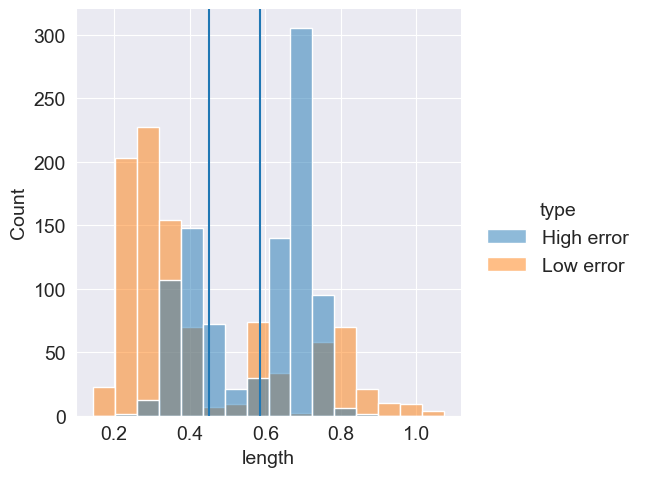

<Figure size 640x480 with 0 Axes>

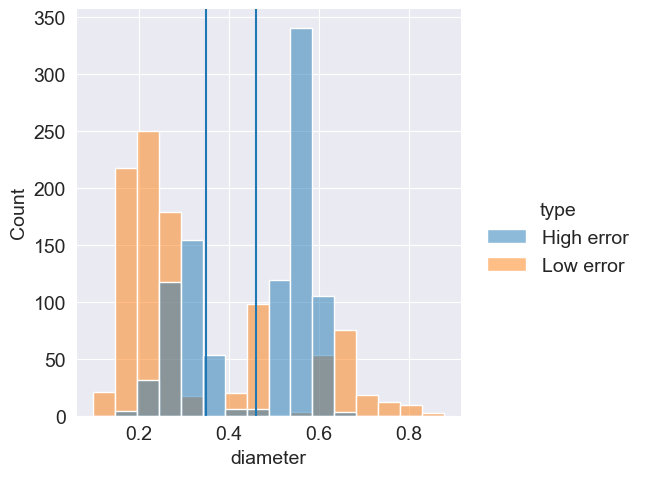

<Figure size 640x480 with 0 Axes>

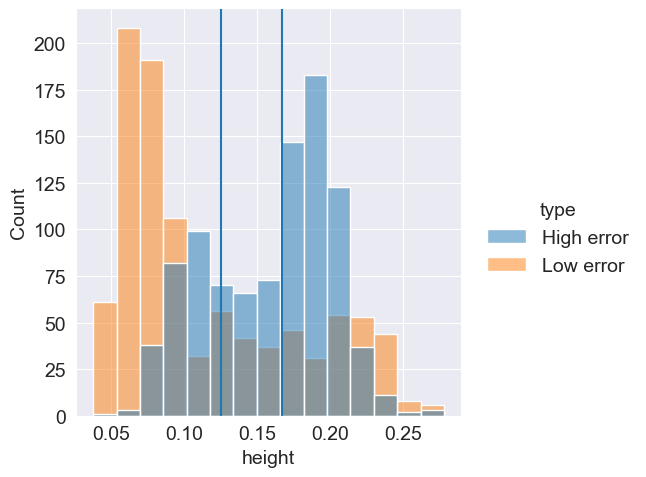

<Figure size 640x480 with 0 Axes>

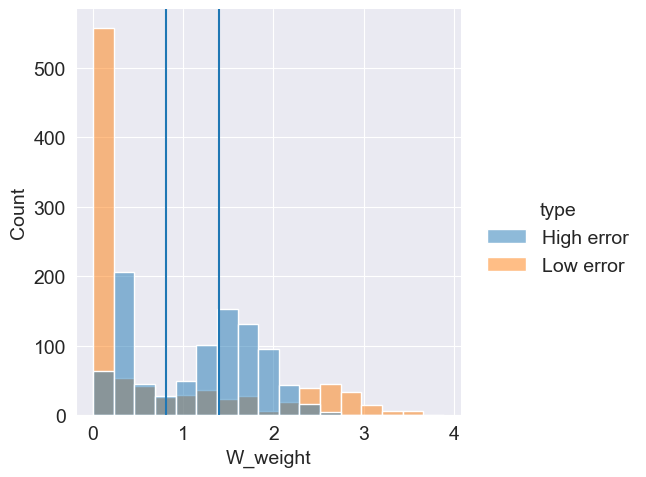

<Figure size 640x480 with 0 Axes>

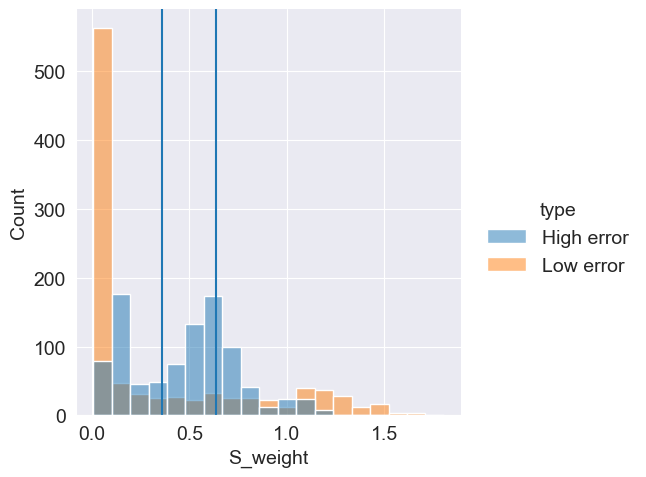

<Figure size 640x480 with 0 Axes>

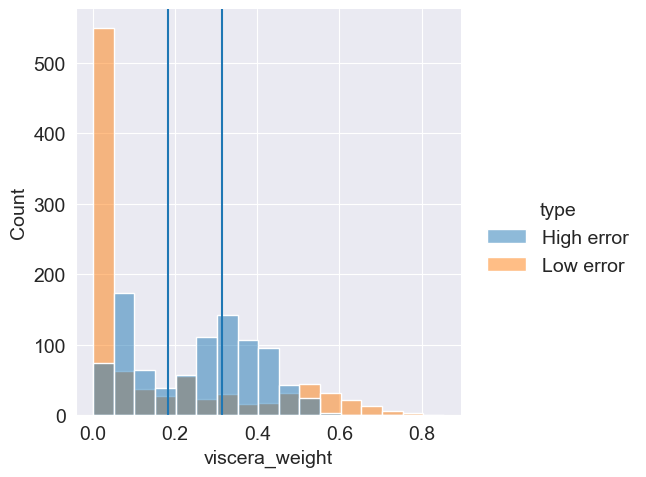

<Figure size 640x480 with 0 Axes>

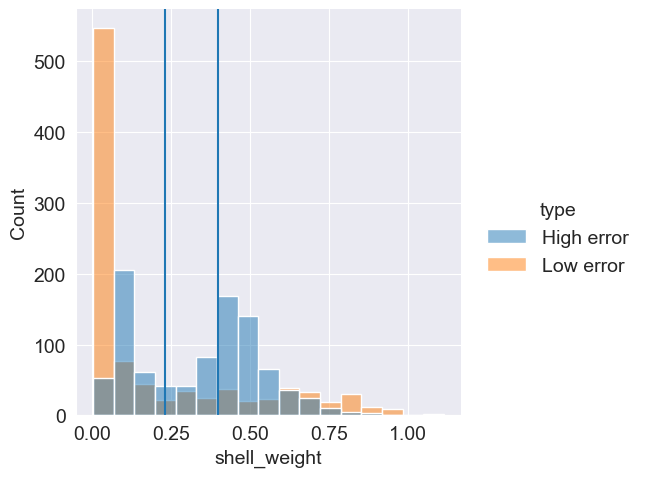

<Figure size 640x480 with 0 Axes>

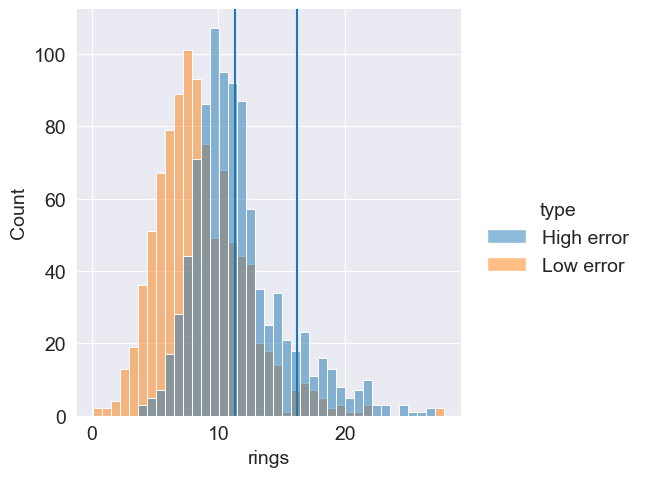

<Figure size 640x480 with 0 Axes>

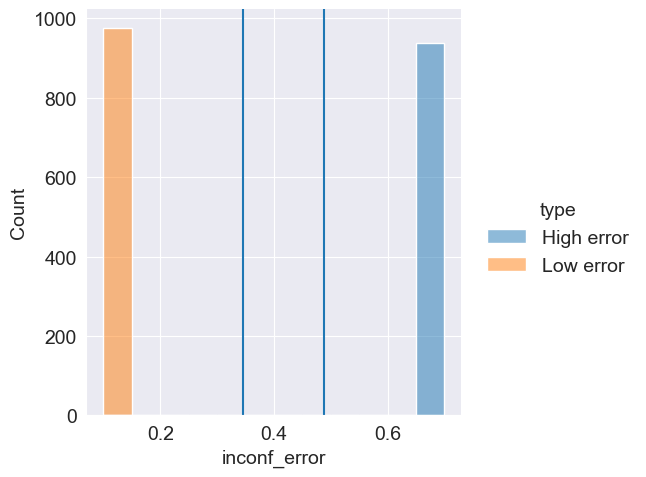

In [114]:
he_data["type"] = "High error"
le_data["type"] = "Low error"
all_data = pd.concat([he_data, le_data])
for i, feat in enumerate(pipeline_data["cont_features"]):
    plt.figure()
    sns.displot(all_data, x=feat, hue="type")
    for j in [1, 2]:
        plt.axvline(x=pipeline_data["cont_features_edges"][i][j])

In [115]:
synthetic = cbn.sample(3000)

100%|██████████| 3000/3000 [00:47<00:00, 63.69it/s]


<Figure size 640x480 with 0 Axes>

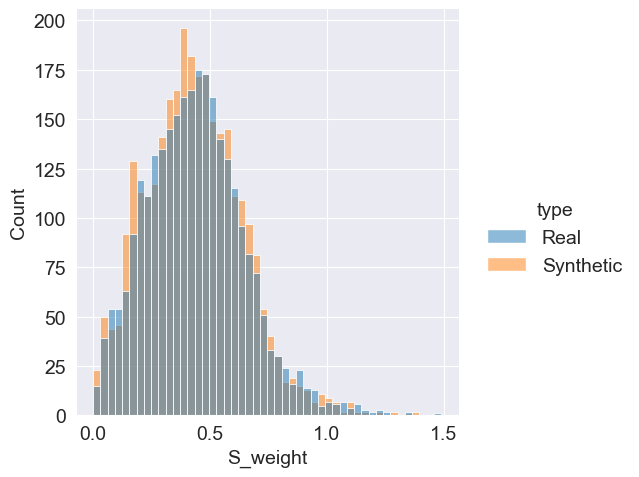

<Figure size 640x480 with 0 Axes>

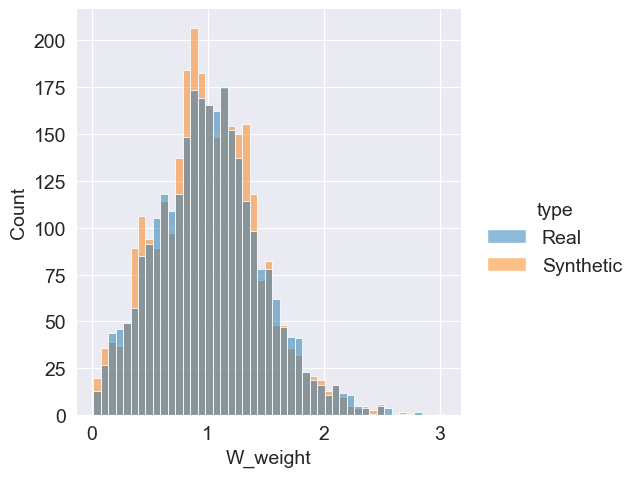

<Figure size 640x480 with 0 Axes>

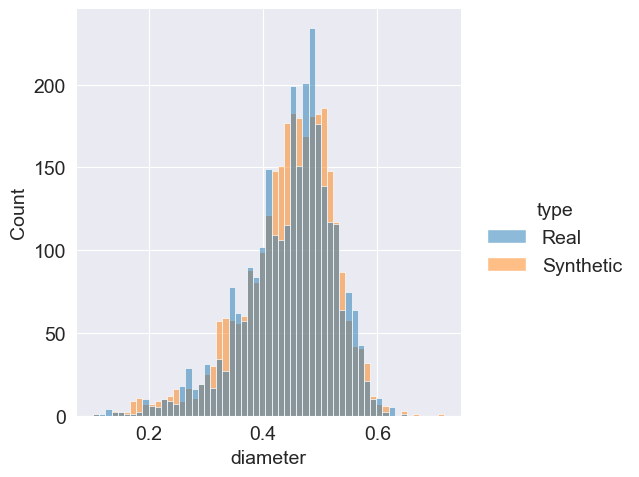

<Figure size 640x480 with 0 Axes>

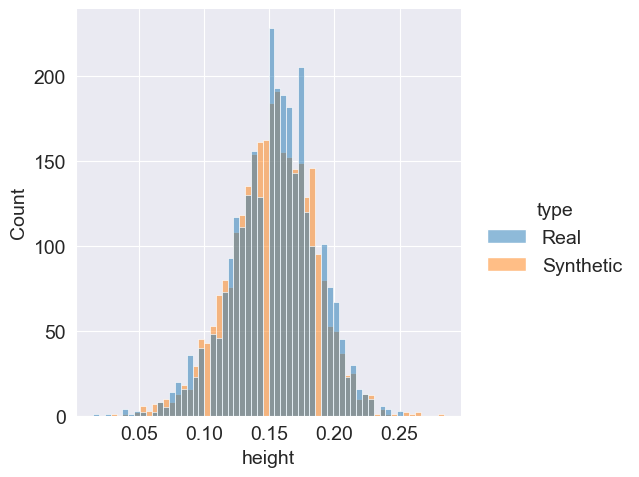

<Figure size 640x480 with 0 Axes>

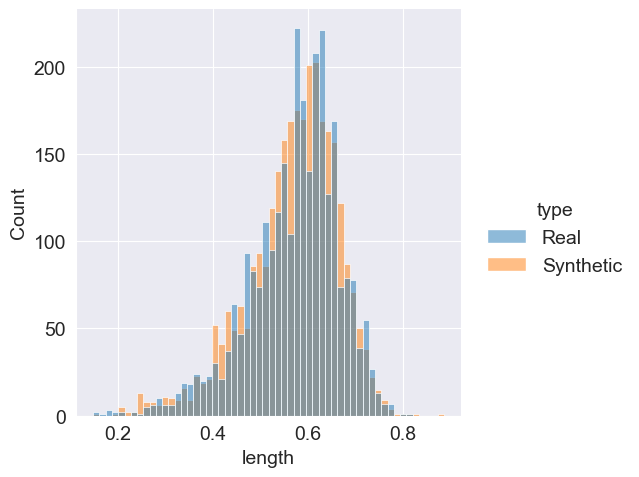

<Figure size 640x480 with 0 Axes>

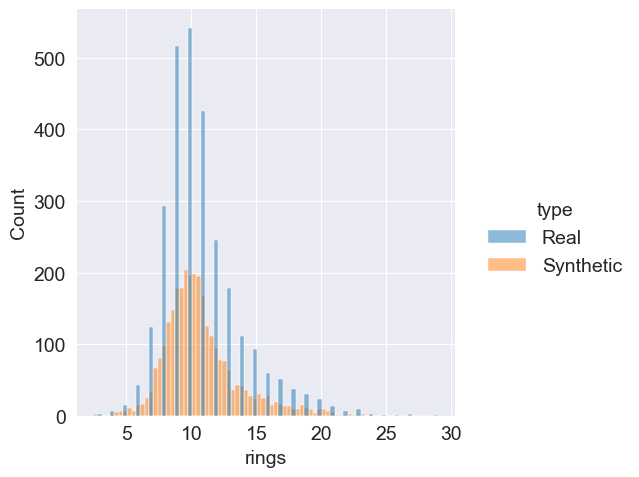

<Figure size 640x480 with 0 Axes>

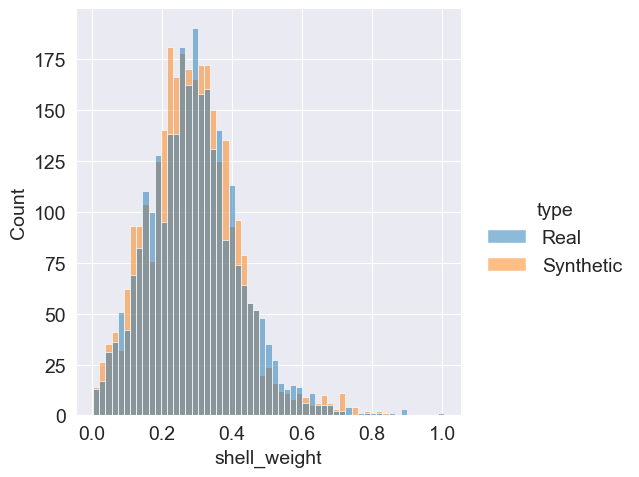

<Figure size 640x480 with 0 Axes>

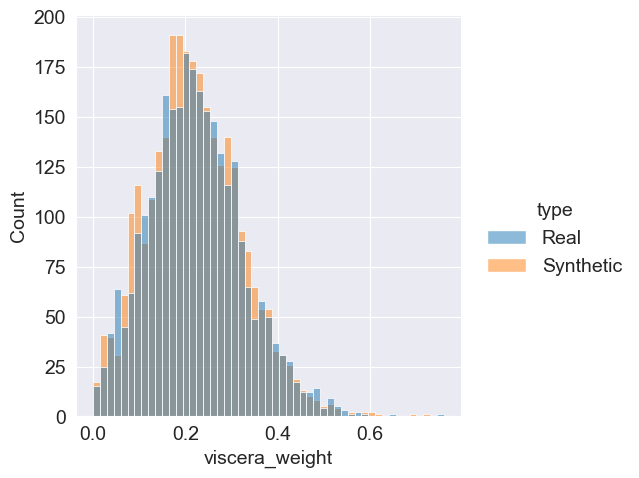

In [116]:
data_c = data_errors.copy()
data_c["type"] = "Real"
synthetic["type"] = "Synthetic"
all_data = pd.concat([data_c, synthetic])
for feat in features:
    plt.figure()
    sns.displot(all_data, x=feat, label="Real", hue="type")

Закладываем ошибку на уровне 0.7

In [117]:
HEdata = cbn.sample(3000, evidence={"inconf_error": 0.7})[data_errors.columns]

100%|██████████| 3000/3000 [00:45<00:00, 66.15it/s]


In [69]:
HEdata.columns

Index(['sex', 'length', 'diameter', 'height', 'W_weight', 'S_weight',
       'viscera_weight', 'shell_weight', 'rings', 'inconf_error'],
      dtype='object')

In [81]:
from copy import copy
from sklearn.metrics import log_loss, roc_auc_score
def inconfidence_score(y_true, y_pred):
    return np.mean((1 - y_pred) * y_true + y_pred * (1 - y_true))

def inconfidence_score_ew(y_true, y_pred):
    return (1 - y_pred) * y_true + y_pred * (1 - y_true)

In [77]:
HEdata[target]

0       1
1       0
2       1
3       1
4       1
       ..
2980    0
2981    1
2982    0
2983    1
2984    1
Name: sex, Length: 2985, dtype: object

In [118]:

HEpred = model.predict_proba(HEdata[features])[:, 1]
errors = inconfidence_score_ew(HEdata[target].astype(int), HEpred)
error = inconfidence_score(HEdata[target].astype(int), HEpred)
errors

0       0.650709
1       0.698381
2       0.614518
3       0.822229
4       0.475450
          ...   
2823    0.442155
2824    0.505009
2825    0.587457
2826    0.483251
2827    0.676588
Name: sex, Length: 2828, dtype: float64

In [119]:
error

0.5898647633954957

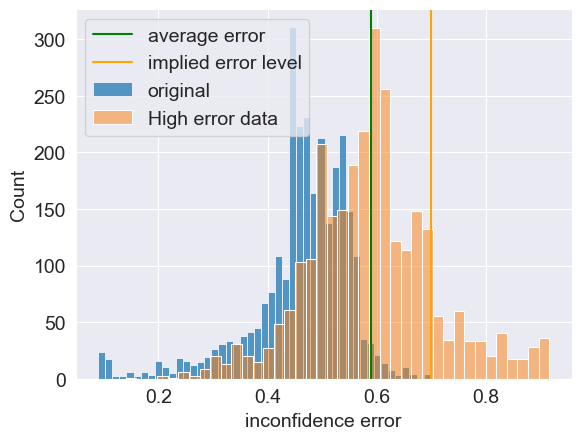

In [120]:
sns.histplot(data_errors["inconf_error"], label="original")
sns.histplot(errors, label="High error data", alpha=0.5)
plt.axvline(error, label="average error", color="g")
plt.axvline(0.7, label="implied error level", color="orange")
plt.xlabel("inconfidence error")
plt.legend()

In [121]:
#all metrics before and after enrichment
for metric in [inconfidence_score, log_loss, roc_auc_score]:
    bef = metric(data[target].astype(int), probs)
    aft = metric(HEdata[target].astype(int), HEpred)
    print(f"Before {bef: .3f} , after {aft: .3f}")

Before  0.462 , after  0.590
Before  0.633 , after  0.944
Before  0.714 , after  0.120


In [124]:
enriched_data = pd.concat([data, HEdata[features + [target]]])
enriched_data[target] = enriched_data[target].astype(int)
model1 = copy(model)
model1.fit(enriched_data[features], enriched_data[target])


GradientBoostingClassifier(n_estimators=50)

In [125]:
predEN = model.predict_proba(enriched_data[features])[:, 1]

In [126]:
errorse = inconfidence_score_ew(enriched_data[target].astype(int), predEN)
errore = inconfidence_score(enriched_data[target].astype(int), predEN)
errorse

0       0.271968
1       0.240691
2       0.548336
3       0.469697
4       0.539360
          ...   
2823    0.442155
2824    0.505009
2825    0.587457
2826    0.483251
2827    0.676588
Name: sex, Length: 5661, dtype: float64

In [127]:
current_error, errore

(0.4612121475189436, 0.5256445838365424)

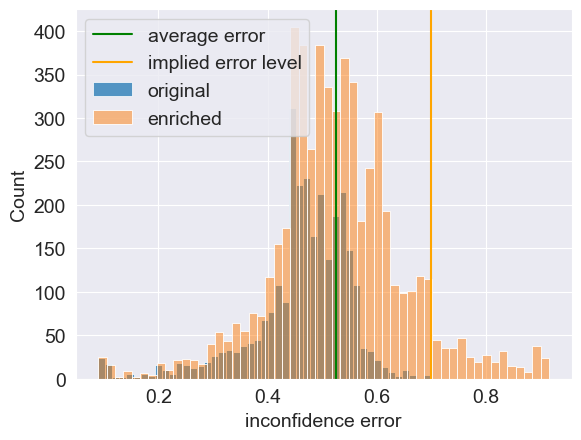

In [128]:
sns.histplot(data_errors["inconf_error"], label="original")
sns.histplot(errorse, label="enriched", alpha=0.5)
plt.axvline(errore, label="average error", color="g")
plt.axvline(0.7, label="implied error level", color="orange")
plt.xlabel("inconfidence error")
plt.legend()

In [129]:
#all metrics before and after enrichment
for metric in [inconfidence_score, log_loss, roc_auc_score]:
    bef = metric(data[target], probs)
    aft = metric(enriched_data[target], predEN)
    print(f"Before {bef: .3f} , after {aft: .3f}")

Before  0.462 , after  0.526
Before  0.633 , after  0.788
Before  0.714 , after  0.365


In [ ]:
roc_auc_score

In [ ]:
bn.predict(pd.DataFrame(disc_data[disc_data["inconf_error"]==2]["inconf_error"]))

In [ ]:
data_errors

In [ ]:
pgmpy_bn = BayesianNetwork([list(e) for e in bn.edges])
cpds = collect_all_cpds(bn.get_info(), bn.distributions, n_states_map)
for e in cpds:
    if len(e.variables) == 1: # либо узел без родителей, либо изолированный узел
        feat = e.variables[0]
        if not any([(feat in edge) for edge in bn.edges]):
            continue
    pgmpy_bn.add_cpds(e)

In [ ]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 0}, nbars=10)

In [ ]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 1}, nbars=10)

In [ ]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 2}, nbars=10)

трактуем так: вероятность того, что ошибка регрессии будет высокой, наиболее чувствительна к изменению параметра, отвечающего за условную вероятность ошибки быть высокой при условии высокого УФ-индекса (здесь 1 маскимальный) и среднего давления

In [ ]:
current_error

In [ ]:
from copy import copy

# BicScore boosting: diameter = High, shell_weight = Mid
# K2Score boosting: нет рекомендаций
# logreg: [S_weight, diameter, rings, shell_weight, viscera_weight] = [0, 1, 0, 0, 0]

In [ ]:
from sklearn.metrics import log_loss
from random import choices

In [ ]:
def inconfidence_score(y_true, y_pred):
    return np.mean((1-y_pred)*y_true + y_pred*(1-y_true))

In [ ]:
dfeat = ["length", "shell_weight"]
dcat = [2, 1]
#dfeat = ["diameter"]
#dcat = [1]
bootn = n
def bootstrap_sampling(dfeat, dcat, trials=1000, alpha=0):
    
    diffs = list()
    mses_before, mses_after = list(), list()
    n_dropped = list()
    
    #пробуем побутсрапировать выборку, чтобы оценить значимость различий в ошибках регрессии
    for i in tqdm(range(trials)):
        indexes = np.random.randint(n, size=bootn)
        bsample = data.iloc[indexes]
        
        bsample_disc = pd.DataFrame(pipeline_data["transformer"].transform(bsample), columns=features+[target])
        
        mask = False
        for feat, cat in zip(dfeat, dcat):
            mask = mask | (bsample_disc[feat]==cat)
        
        X1, y1 = bsample[features], bsample[target]
        model1, model2 = copy(model), copy(model)
        model1.fit(X1, y1)
        y1_pred = model1.predict(X1)
        indexes_to_drop = np.random.choice(bsample[mask].index, size=int(np.floor(bsample[mask].shape[0]*(1-alpha))), replace=False)
        
        new_bsample = bsample.drop(index=indexes_to_drop)
        
        X2, y2 = new_bsample[features], new_bsample[target]
        
        model2.fit(X2, y2)
        
        y2_pred = model2.predict(X2)
        mses_before.append(inconfidence_score(y1, y1_pred))
        mses_after.append(inconfidence_score(y2, y2_pred))
        diffs.append(inconfidence_score(y1, y1_pred) - inconfidence_score(y2, y2_pred))
        n_dropped.append(indexes_to_drop.shape[0])
        
    return mses_before, mses_after, diffs, sum(n_dropped)/trials

In [ ]:
data.shape

In [ ]:
np.random.seed(42)
mses_before, mses_after, diffs = bootstrap_sampling(dfeat, dcat, trials=500)

In [ ]:
percentage_changes = list()
mean_differences = list()
alphas = np.linspace(0, 1, 11)
for a in alphas[:-1]:
    np.random.seed(42)
    mses_before, mses_after, diffs, _ = bootstrap_sampling(dfeat, dcat, trials=500, alpha=a)
    if a == 0:
        print(_)
    x, y = np.array(mses_before), np.array(mses_after)
    mean_differences.append((x-y).mean())
    percentage_changes.append(((y-x)/x).mean()*100)
percentage_changes.append(0)
mean_differences.append(0)

In [ ]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [ ]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [ ]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [ ]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [ ]:
from scipy.stats import ttest_rel

In [ ]:
ttest_rel(mses_before, mses_after)

In [ ]:
ttest_rel(mses_before, mses_after)

In [ ]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

In [ ]:
from itertools import product

In [ ]:
gbn = DiscreteBNGI(imagespath)
gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
features_cats = [x for x in disc_data_encoded.columns if "sq_error" not in x]
error_cats = [x for x in disc_data_encoded.columns if "sq_error" in x]
blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

gbn.add_edges(disc_data_encoded, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

In [ ]:
gbn.get_info()


# k2score boosting: нет рекомендаций
# regression : [Tsurf_mean_0, pressure_2]

In [ ]:
dfeat = ["S_weight", "shell_weight"]
dcat = [0, 0]
np.random.seed(42)
mses_before, mses_after, diffs = bootstrap_sampling(dfeat, dcat, trials=500)

In [ ]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [ ]:
ttest_rel(mses_before, mses_after)

In [ ]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [ ]:
ttest_rel(mses_before, mses_after)

In [ ]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [ ]:
ttest_rel(mses_before, mses_after)

In [ ]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_onehot = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')

In [ ]:
disc_data_onehot

In [ ]:
gbn = DiscreteBNGI(imagespath)

In [ ]:
variables=["X1", "X2"]
#gbn.add_nodes(kresult["bn"].descriptor)
#grads = [feat+'_'+str(k) for feat in variables for k in range(n_states_map[feat])]
grads = [feat+'_'+str(k) for feat in variables for k in range(3)]
gbn.add_nodes({"types": {feat: "disc" for feat in grads}})
#gbn.set_edges(grad_edges)
gbn.add_edges(data=disc_data_onehot, scoring_function=("K2", K2Score))

In [ ]:
c=gbn.plot("regression.html")

In [ ]:
disc_data_errors, pipeline_data_errors = discretize(data_errors, variables=data_errors.columns.tolist(), icat=None, icont=[0, 1])

In [ ]:
disc_data_errors

In [ ]:
kresultresid = construct_by_kmeans(data_residuals, [], scoring=("K2", K2Score))

In [ ]:
c=kresultresid["bn"].plot2(imagespath, "residuals.html")